# Import Library

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Update adding feature callbacks : Mengambil weight/bobot terbaik saat proses training yang berfungsi untuk mempercepat waktu pembelajaran dengan last point step adalah weight terbaik.

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Cek TF Version

In [3]:
print(tf.__version__)

2.12.0-rc1


# Import Dataset yang sudah dibersihkan

In [4]:
dataset_dir = os.path.join(os.path.dirname('dataset'), 'DATASET/DTS3000/')

# Melihat Direktori Dataset

In [5]:
os.listdir(dataset_dir)

['TEST', 'TRAIN']

# Set Data untuk Training

In [6]:
train_dir = os.path.join(dataset_dir, 'TRAIN')
os.listdir(train_dir)

['EKO', 'KES', 'OLA', 'POL']

# Set Data untuk Testing

In [7]:
test_dir = os.path.join(dataset_dir, 'TEST')
os.listdir(train_dir)

['EKO', 'KES', 'OLA', 'POL']

# Sampling Data untuk di Training

In [8]:
sample_file = os.path.join(train_dir, 'KES/KES125.txt')

with open(sample_file) as f:
  print(f.read())

8 kebiasaan tidur siang yang buruk malah bikin otak lemot


tf.keras.utils.text_dataset_from_directory adalah sebuah fungsi yang disediakan oleh TensorFlow yang digunakan untuk memuat data teks dari direktori pada sistem file. Fungsi ini membantu dalam mempersiapkan data dalam bentuk yang sesuai untuk pemrosesan menggunakan model pembelajaran mesin.

Fungsi ini dapat membaca semua file teks dalam direktori tertentu dan mengorganisasikannya ke dalam dua set data, yaitu data latih dan data validasi, dengan pembagian data yang dapat dikonfigurasi oleh pengguna. Fungsi ini juga dapat menghasilkan sebuah objek tf.data.Dataset yang dapat digunakan untuk memasukkan data ke dalam model pembelajaran mesin.

Pengguna dapat menentukan parameter seperti batch_size, seed, validation_split, subset, labels, dan sebagainya untuk mengatur bagaimana data akan dibagi dan disiapkan untuk model.

Dalam keseluruhan, fungsi tf.keras.utils.text_dataset_from_directory sangat berguna bagi para pengembang dan peneliti yang bekerja dengan pemrosesan bahasa alami dan ingin mempersiapkan data teks dalam format yang sesuai untuk diproses dengan model pembelajaran mesin.

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'DATASET/DTS3000//TRAIN', 
    batch_size=batch_size, 
    validation_split=0.2, # Parto law 80:20
    subset='training', # ini digunakan untuk data yang akan di training
    seed=seed)

Found 2400 files belonging to 4 classes.
Using 1920 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'jelang persaingan panas perebutan titel juara dunia di motogp valencia 2022 fabio quartararo justru santai'
Label 2
Review b'ojk potensi kredit bermasalah terus meningkat seiring dampak pandemi pada ekonomi'
Label 0
Review b'penyakit kanker terkait gen dipengaruhi faktor lingkungan'
Label 1


In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to EKO
Label 1 corresponds to KES
Label 2 corresponds to OLA
Label 3 corresponds to POL


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'DATASET/DTS3000/TRAIN', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 2400 files belonging to 4 classes.
Using 480 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'DATASET/DTS3000/TEST', 
    batch_size=batch_size)

Found 604 files belonging to 4 classes.


# Fungsi untuk menstandarkan string input

In [14]:
def custom_standardization(input_data):
  # Membuat Semua String menjadi Lower String/ huruf kecil Semua
  lowercase = tf.strings.lower(input_data)
  # Menghapus apabila ada html tag

  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

# TextVectorization

Textvectorization adalah pre-processing sebelum proses pembelajaran yang mengubah string mentah kedalam bentuk intger yang dapat dibaca oleh lapisan berikutnya dalam Layer, berikutnya contoh embeding dan denses:

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    # Memanggil fungsi sebelumnya yang mestandarkan semua string input menjadi lower case dan menghilangkan tag html bila ada
    standardize=custom_standardization,
    # Memberikan batasan padding agar panjang matrix sama pada setiap masukan.
    max_tokens=max_features,
    # Output String akan diubah menjadi bentuk integer
    output_mode='int',
    output_sequence_length=sequence_length)

''' Selanjutnya, memanggil adapt agar sesuai dengan keadaan lapisan preprocessing ke dataset. Ini akan menyebabkan model membangun indeks string menjadi bilangan bulat. '''

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Fungsi untuk mengubah setiap string text input ke dalam bentuk intger dan menyimpan dalam array, dengan menggunakan vectorize_layer yang telah diset diatas.

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  #print(text)
  return vectorize_layer(text), label

In [18]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[12], label_batch[12]
print("\nReview -> text_batch[12]", first_review)
print("Label -> Label_batch[12]", raw_train_ds.class_names[first_label])
print("\nVectorized review nya seperti ini \n\n", vectorize_text(first_review, first_label))


Review -> text_batch[12] tf.Tensor(b'fakta dan ahistoris pisahkan olahraga dari politik', shape=(), dtype=string)
Label -> Label_batch[12] POL

Vectorized review nya seperti ini 

 (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 803,    3, 4629, 2893,   86,   20,   27,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

# Pembuktian terbalik TextVectorization

In [19]:
print("803 ---> ",vectorize_layer.get_vocabulary()[803])
print("3 ---> ",vectorize_layer.get_vocabulary()[3])
print("4629 ---> ",vectorize_layer.get_vocabulary()[4629])
print("2893 ---> ",vectorize_layer.get_vocabulary()[2893])
print("86 ---> ",vectorize_layer.get_vocabulary()[86])
print("20 ---> ",vectorize_layer.get_vocabulary()[20])
print("27 ---> ",vectorize_layer.get_vocabulary()[27])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

803 --->  fakta
3 --->  dan
4629 --->  ahistoris
2893 --->  pisahkan
86 --->  olahraga
20 --->  dari
27 --->  politik
Vocabulary size: 4740


# Perubahan nilai Integer dari vectorization kedalam bentuk encode-decode pada Embedding

In [20]:
embedding_dim = 16

In [21]:
print(layers.Embedding(max_features + 1, embedding_dim)(tf.constant([803,3, 4629, 2893, 86, 20, 27])))

tf.Tensor(
[[-4.33210842e-02 -4.15019281e-02 -3.27414274e-02  4.36860658e-02
  -2.02108752e-02  3.44457142e-02  2.24701874e-02 -4.13199179e-02
  -2.19476819e-02 -3.12206876e-02 -2.62201559e-02 -3.32435854e-02
  -4.34179902e-02 -8.97703320e-03 -1.58826001e-02 -1.46057718e-02]
 [-2.95047518e-02  3.41185182e-03  4.21099402e-02  7.53413513e-03
  -3.69024388e-02 -3.14653739e-02 -1.30129568e-02 -1.15766302e-02
   2.33402289e-02 -1.93963051e-02  4.88935970e-02 -1.90222505e-02
   2.09857561e-02  3.48442905e-02 -4.60691117e-02  4.94305603e-02]
 [ 3.06503214e-02  1.22777447e-02 -4.77907062e-02  1.75229944e-02
  -3.19764018e-02  1.07434876e-02  2.12496780e-02  4.13377620e-02
   1.35659687e-02  5.26793301e-05 -1.18252635e-02  3.61453407e-02
  -4.96471189e-02  3.01476456e-02 -2.65989788e-02 -4.12615314e-02]
 [-4.39442880e-02  7.84766674e-03 -4.52078469e-02 -1.22721680e-02
  -2.98133250e-02  7.89096206e-03 -3.23884860e-02 -2.69295704e-02
  -3.53457779e-03  2.36381218e-03  2.00798400e-02  4.04154994e

# Menggubah semua input train, validasi dan test kedalam bentuk integer

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [23]:
# Tunning dataset train, validasi dan test dengan AUTOTUNE untuk optimisasi shape data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Layer embedding dimension kita set menjadi 16 , fungsi embedding ini hanya dapat digunakan pada integer positiv dan untuk memperbaiki matrix.

In [ ]:
embedding_dim = 16

# Membangun Model RNN

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  #layers.Bidirectional(tf.keras.layers.LSTM(16)),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()



img_file = 'model_arch.png'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

In [26]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath='BEST_AJA.h5',save_best_only=True, save_weights_only=True)

In [35]:
epochs = 150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint])

Epoch 1/150
60/60 [==============================] - 1s 10ms/step - loss: 0.0097 - accuracy: 0.9990 - val_loss: 0.1468 - val_accuracy: 0.9479
Epoch 2/150
60/60 [==============================] - 1s 10ms/step - loss: 0.0097 - accuracy: 0.9995 - val_loss: 0.1480 - val_accuracy: 0.9417
Epoch 3/150
60/60 [==============================] - 1s 11ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 0.1467 - val_accuracy: 0.9521
Epoch 4/150
60/60 [==============================] - 1s 12ms/step - loss: 0.0101 - accuracy: 0.9995 - val_loss: 0.1461 - val_accuracy: 0.9500
Epoch 5/150
60/60 [==============================] - 1s 12ms/step - loss: 0.0089 - accuracy: 0.9995 - val_loss: 0.1470 - val_accuracy: 0.9438
Epoch 6/150
60/60 [==============================] - 1s 13ms/step - loss: 0.0094 - accuracy: 0.9990 - val_loss: 0.1478 - val_accuracy: 0.9458
Epoch 7/150
60/60 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 0.1459 - val_accuracy: 0.9500
Epoch 

# Save Model

In [38]:
model.save('RNN_MODEL_BASIC_030523.h5')

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

19/19 [==============================] - 1s 13ms/step - loss: 0.2622 - accuracy: 0.9338
Loss:  0.26221081614494324
Accuracy:  0.9337748289108276


In [34]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

19/19 [==============================] - 0s 4ms/step - loss: 0.2108 - accuracy: 0.9371
Loss:  0.21082817018032074
Accuracy:  0.9370861053466797


In [36]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

19/19 [==============================] - 0s 3ms/step - loss: 0.2138 - accuracy: 0.9321
Loss:  0.21377287805080414
Accuracy:  0.9321191906929016


In [37]:
epoch_set = [150,150,150]
epoch_real = [150,102,12]
loss = [0.26221081614494324,0.21082817018032074,0.21377287805080414]
acc = [ 0.9337748289108276,0.9370861053466797,0.9321191906929016]

data_rnn_basic = pd.DataFrame()
data_rnn_basic['epoch_set']= epoch_set
data_rnn_basic['epoch_real']= epoch_real
data_rnn_basic['loss']= loss
data_rnn_basic['acc']= acc

display(data_rnn_basic)


,epoch_set,epoch_real,loss,acc
0,150,150,0.262211,0.933775
1,150,102,0.210828,0.937086
2,150,12,0.213773,0.932119


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Melihat Nilai Akurasi & Loss Menggunakan Grafik

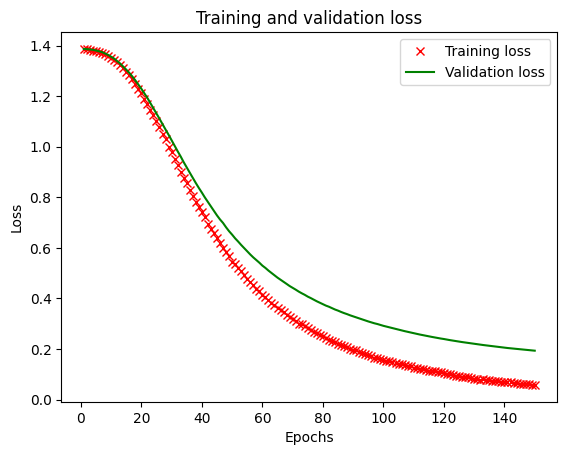

In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'rx', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

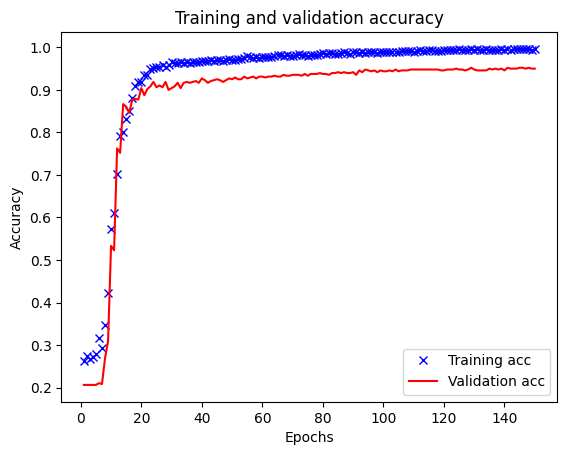

In [32]:
plt.plot(epochs, acc, 'bx', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Memberikan fungsi aktivasi pada output hasil prediksi

In [39]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])
export_model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])



# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 1s 12ms/step - loss: 0.2138 - accuracy: 0.9321
0.9321191906929016


In [40]:
['EKO', 'KES', 'OLA','POL']

['EKO', 'KES', 'OLA', 'POL']

# Prediksi

In [41]:
examples = ["MotoGP 2015 akan dikenang sebagai salah satu yang paling sengit dalam gelaran kejuaraan dunia balap motor grand prix",
            "Ida Fauziyah menargetkan penyaluran Ekonomi Bantuan Subsidi Upah (BSU) atau BLT Gaji melalui PT Pos",
            "Teknik Dasar Jalan Cepat, Sejarah, dan Manfaat untuk Kesehatan",
            "Covid-19 akan meningkat apabila masayarakat tidak patuh protokol kesehatan",
            "Rencana Impor KRL Bekas Didukung Erick Thohir, tetapi belum mendapat persetujuan kementrian perdagangan & Ekonomi",
            "Inflasi Indonesia Naik Lagi pada Februari 2023",
            "Pemilu 2024 diikuti oleh 4 partai politik"]


#for x in examples:
export_model.predict(examples)

1/1 [==============================] - 0s 455ms/step


array([[3.7752223e-05, 3.1191852e-05, 9.9989235e-01, 3.8705068e-05],
       [9.9985838e-01, 3.5329304e-05, 2.6091991e-05, 8.0115999e-05],
       [2.0367149e-02, 9.5237654e-01, 7.0512202e-03, 2.0205034e-02],
       [9.7955810e-03, 9.8547482e-01, 1.2721439e-03, 3.4574668e-03],
       [9.9798715e-01, 1.3451706e-05, 2.8746550e-05, 1.9705824e-03],
       [9.8689306e-01, 7.9145255e-03, 4.2830203e-03, 9.0932229e-04],
       [1.9884341e-05, 5.9132923e-05, 6.4260879e-05, 9.9985671e-01]],
      dtype=float32)

# Fungsi unuk Membuat VisuaIisasi Grafik Pie Chart

In [42]:
def Pie_Chart_Visualization(x):

          # Pie chart, where the slices will be ordered and plotted counter-clockwise:
          labels = ['EKO', 'KES', 'OLA', 'POL']
          sizes = export_model.predict(examples)[x].tolist()
     

          explode = (0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
          
          fig1, ax1 = plt.subplots()
          ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                  shadow=True, startangle=90)
          ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

          plt.show()

def Winner(x):

          winner = np.argmax(export_model.predict(examples)[x])

          if winner == 0:
            print('Best Prediction Adalah : Ekonomi \n')
          elif winner == 1:
            print('Best Prediction Adalah : Kesehatan \n')
          elif winner == 2:
            print('Best Prediction Adalah : Olahraga \n')            
          else :
            print('Best Prediction Adalah : Politik \n')

'MotoGP 2015 akan dikenang sebagai salah satu yang paling sengit dalam gelaran kejuaraan dunia balap motor grand prix'

1/1 [==============================] - 0s 68ms/step


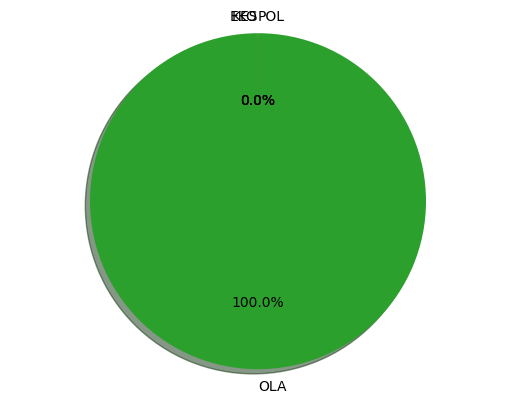

None

1/1 [==============================] - 0s 91ms/step
Best Prediction Adalah : Olahraga 



'Ida Fauziyah menargetkan penyaluran Ekonomi Bantuan Subsidi Upah (BSU) atau BLT Gaji melalui PT Pos'

1/1 [==============================] - 0s 91ms/step


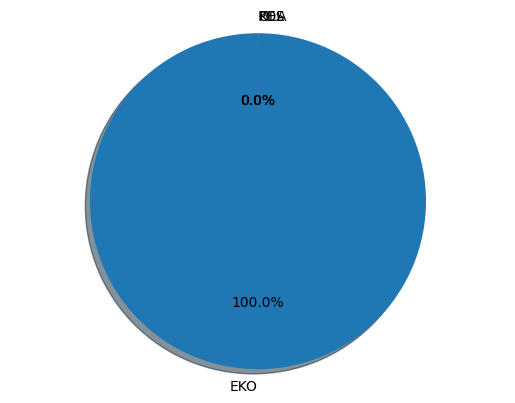

None

1/1 [==============================] - 0s 66ms/step
Best Prediction Adalah : Ekonomi 



'Teknik Dasar Jalan Cepat, Sejarah, dan Manfaat untuk Kesehatan'

1/1 [==============================] - 0s 52ms/step


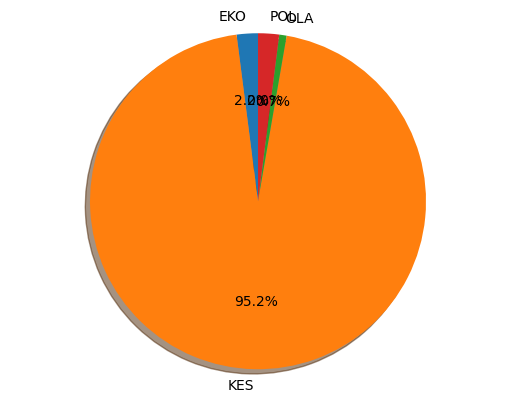

None

1/1 [==============================] - 0s 61ms/step
Best Prediction Adalah : Kesehatan 



'Covid-19 akan meningkat apabila masayarakat tidak patuh protokol kesehatan'

1/1 [==============================] - 0s 82ms/step


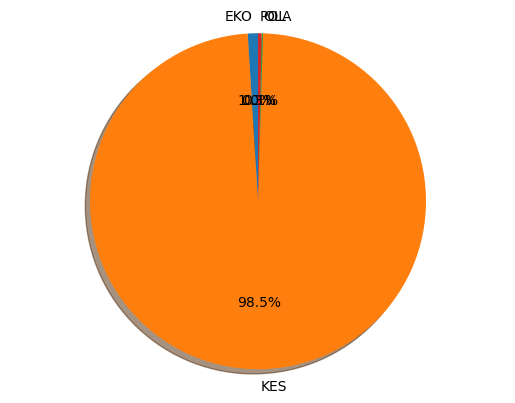

None

1/1 [==============================] - 0s 88ms/step
Best Prediction Adalah : Kesehatan 



'Rencana Impor KRL Bekas Didukung Erick Thohir, tetapi belum mendapat persetujuan kementrian perdagangan & Ekonomi'

1/1 [==============================] - 0s 92ms/step


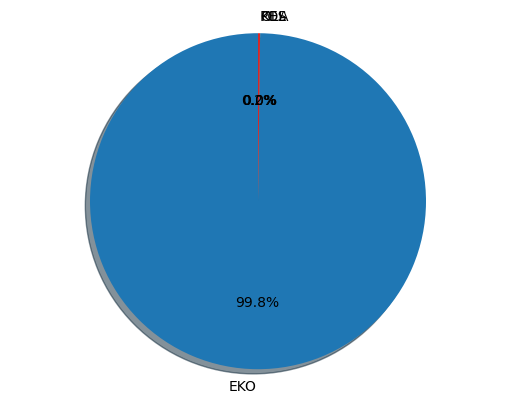

None

1/1 [==============================] - 0s 83ms/step
Best Prediction Adalah : Ekonomi 



'Inflasi Indonesia Naik Lagi pada Februari 2023'

1/1 [==============================] - 0s 101ms/step


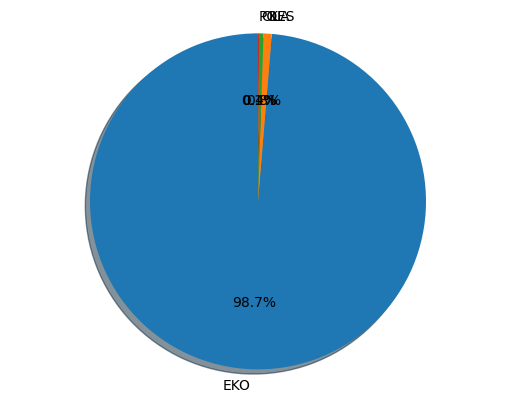

None

1/1 [==============================] - 0s 118ms/step
Best Prediction Adalah : Ekonomi 



'Pemilu 2024 diikuti oleh 4 partai politik'

1/1 [==============================] - 0s 76ms/step


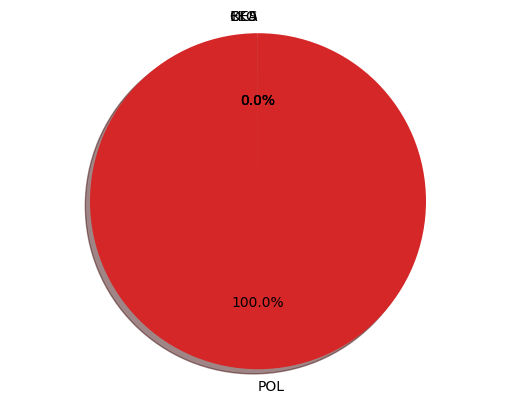

None

1/1 [==============================] - 0s 56ms/step
Best Prediction Adalah : Politik 



In [43]:
for x in range(len(examples)):
  display(examples[x])
  display(Pie_Chart_Visualization(x))
  Winner(x)

# Mengukur Kinerja Model Menggunakan Confusion Matrix

In [44]:
import glob


EKO_TEST = []

for x in glob.glob('DATASET/DTS3000/TEST/EKO/*.txt'):
  with open(x) as dat:
    dat = dat.read()
    for x in dat.split('\n'):
      EKO_TEST.append(x)

########################      

HEL_TEST = []

for x in glob.glob('DATASET/DTS3000/TEST/KES/*.txt'):
  with open(x) as dat:
    dat = dat.read()
    for x in dat.split('\n'):
      HEL_TEST.append(x)

########################   

OLA_TEST = []

for x in glob.glob('DATASET/DTS3000/TEST/OLA/*.txt'):
  with open(x) as dat:
    dat = dat.read()
    for x in dat.split('\n'):
      OLA_TEST.append(x)

########################   

POL_TEST = []

for x in glob.glob('DATASET/DTS3000/TEST/POL/*.txt'):
  with open(x) as dat:
    dat = dat.read()
    for x in dat.split('\n'):
      POL_TEST.append(x)

########################   

EKO_TEST_REAL =  [0 for i in range(len(EKO_TEST))]
EKO_TEST_PRE = []

HEL_TEST_REAL =  [1 for i in range(len(HEL_TEST))]
HEL_TEST_PRE = []

OLA_TEST_REAL =  [2 for i in range(len(OLA_TEST))]
OLA_TEST_PRE = []

POL_TEST_REAL =  [3 for i in range(len(POL_TEST))]
POL_TEST_PRE = []

#export_model.predict(EKO_TEST)   

for x in range(len(EKO_TEST)):
    AA = (np.argmax(export_model.predict(EKO_TEST)[x]))
    EKO_TEST_PRE.append(AA)

for x in range(len(HEL_TEST)):
    AA = (np.argmax(export_model.predict(HEL_TEST)[x]))
    HEL_TEST_PRE.append(AA)

for x in range(len(OLA_TEST)):
    AA = (np.argmax(export_model.predict(OLA_TEST)[x]))
    OLA_TEST_PRE.append(AA)    

for x in range(len(POL_TEST)):
    AA = (np.argmax(export_model.predict(POL_TEST)[x]))
    POL_TEST_PRE.append(AA)

5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 3]

Text(95.72222222222221, 0.5, 'True labels')

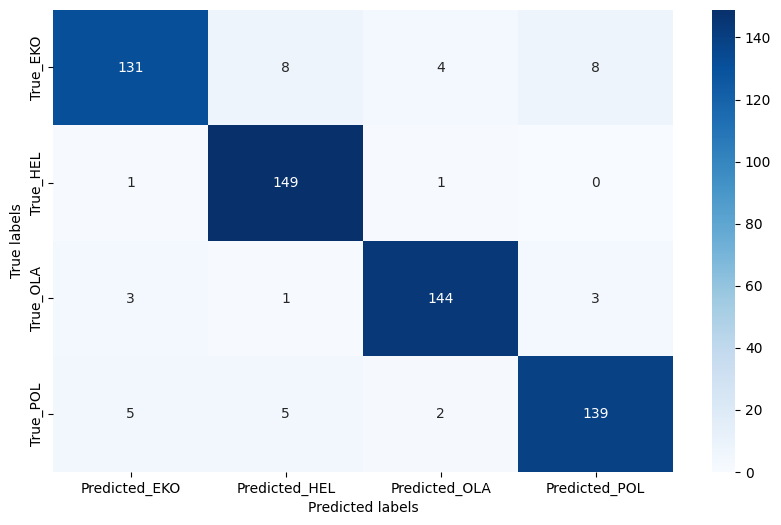

In [46]:
from sklearn.metrics import confusion_matrix


# Define the true and predicted labels
true_labels = EKO_TEST_REAL + HEL_TEST_REAL + OLA_TEST_REAL + POL_TEST_REAL
predicted_labels = EKO_TEST_PRE + HEL_TEST_PRE + OLA_TEST_PRE + POL_TEST_PRE
display(true_labels[:10],predicted_labels[:10])

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a pandas DataFrame
cm_df = pd.DataFrame(cm, index=['True_EKO', 'True_HEL', 'True_OLA', 'True_POL'], columns=['Predicted_EKO', 'Predicted_HEL', 'Predicted_OLA', 'Predicted_POL'])

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')

# Add labels to the confusion matrix

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
#plt.show()   